#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [ ]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning -q
! pip install wandb -q

     |████████████████████████████████| 800 kB 4.9 MB/s 
     |████████████████████████████████| 512 kB 53.5 MB/s 
     |████████████████████████████████| 125 kB 74.7 MB/s 
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 174 kB 72.7 MB/s 
     |████████████████████████████████| 182 kB 75.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 60.2 MB/s 
     |████████████████████████████████| 168 kB 57.2 MB/s 
     |████████████████████████████████| 168 kB 58.8 MB/s 
     |████████████████████████████████| 166 kB 58.1 MB/s 
     |████████████████████████████████| 166 kB 13.0 MB/s 
     |████████████████████████████████| 162 kB 63.0 MB/s 
     |████████████████████████████████| 162 kB 20.8 MB/s 
     |████████████████████████████████| 158 kB 62.6 MB/s 
     |████████████████████████████████| 157 kB 60.6 MB/s 
     |████████████████████████████████| 157 kB 61.1 MB/s 
     |████████████

Скачаем данные

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 16:11 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


## Релизуйте выборку для YoloV1 - 2 балла

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from PIL import Image
from albumentations.pytorch import ToTensorV2
import copy
from PIL import ImageDraw
import secrets
import time
import os
import cv2
import json
import glob
import tqdm
import xmltodict
from IPython.core.display import struct
from typing import List
import albumentations as A
import albumentations.pytorch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tqdm.notebook import tqdm as tqdm
import wandb
import gc
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Connected device is {device}')

Connected device is cuda


In [ ]:
!wandb login

wandb: Currently logged in as: sir_kolbas. Use `wandb login --relogin` to force relogin


Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

"""
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
"""

class FruitDataset(Dataset):
    def __init__(self, data_dir, S=7, B=2, C=3, transforms=None):
        
        self.image_paths = [os.path.join(data_dir, image_path) for image_path in os.listdir(data_dir) if image_path.endswith('.jpg')]
        self.box_paths = [os.path.join(data_dir, box_path) for box_path in os.listdir(data_dir) if box_path.endswith('.xml')]
        
        self.data_dir = data_dir
        self.S = S
        self.B = B
        self.C = C

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)

    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx]).astype(np.float32)/255.0
        boxes, class_labels = self.__get_boxes_from_xml(self.image_paths[idx].replace('.jpg', '.xml'))

        if self.transforms:
            image, boxes, class_labels = self.transforms(image=image, bboxes=boxes, class_labels=class_labels).values()
        
        confidence = 1.0
        #image_size = image.shape[0]
        
        target_tensor = torch.zeros((self.S, self.S, self.C + 5 * self.B), dtype=torch.float)
        stride = 1./self.S
        
        for idx, box in enumerate(boxes):
            x_center, y_center, width, height = box
            label = class_labels[idx]
            
            row = int(np.floor(x_center/stride))
            column = int(np.floor(y_center/stride))

            x_center_est = ((x_center/stride) - row)
            y_center_est = ((y_center/stride) - column)
            width_est = width *self.S
            height_est = height *self.S

            if target_tensor[row, column, self.C+4] == 0:
                
                coord = torch.tensor(
                  [x_center_est, y_center_est, width_est, height_est]
                )
                
                target_tensor[row, column, self.C:self.C+4] = coord
                target_tensor[row, column, label-1] = 1 
                target_tensor[row, column, self.C+4] = confidence #мб и норм так
        
        return image, target_tensor

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный

        за костыль спасибо https://gis.stackexchange.com/questions/385031/xml-bounding-boxes-to-shapefile-qgis
        """
        boxes = []
        class_labels = []

        xml_dict = {}

        with open(xml_filename, 'r') as xml_file:
          
            xml_content = xml_file.read()
            temp_dict = xmltodict.parse(xml_content)
            xml_dict = dict(temp_dict['annotation'])

        objects = xml_dict['object']
        self.coord = []
        
        if all(isinstance(n, dict) for n in objects):
            for obj in objects:
                
                coord_dict = obj.get('bndbox')
                
                x_min = int(coord_dict['xmin'])
                x_max = int(coord_dict['xmax'])
                y_min = int(coord_dict['ymin'])
                y_max = int(coord_dict['ymax'])
                
                self.coord.append([x_min, y_min, x_max, y_max])
                class_labels.append(class2tag.get(obj['name']))
        else:
            
            coord_dict = objects.get('bndbox')
            
            x_min = int(coord_dict['xmin'])
            x_max = int(coord_dict['xmax'])
            y_min = int(coord_dict['ymin'])
            y_max = int(coord_dict['ymax'])
            
            self.coord.append([x_min, y_min, x_max, y_max])
            class_labels.append(class2tag.get(objects['name']))

        if 'train' in  xml_dict['path']:
            path = os.path.join(self.data_dir, xml_dict['path'][61:])
        else:
            path = os.path.join(self.data_dir, xml_dict['path'][60:])
        
        img = Image.open(path)
        img_width, img_height = img.size
        
        for coord in self.coord:
            boxes.append(self.__convert_to_yolo_box_params(coord, img_width, img_height))
        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
        
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

In [ ]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
        A.Resize(HEIGHT, WIDTH),
        A.ColorJitter(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        #A.RandomCropNearBBox(p=0.25),
        ToTensorV2()
    ],  bbox_params=A.BboxParams(format='yolo',
                                 label_fields=['class_labels']))
test_transform = A.Compose([
        A.Resize(HEIGHT, WIDTH),
        ToTensorV2()
    ],
        bbox_params=A.BboxParams(format='yolo',
                                 label_fields=['class_labels']))

#https://albumentations.ai/docs/api_reference/augmentations/transforms/

In [ ]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [ ]:
def intersection_over_union(predicted_bbox, gt_bbox, is_list:bool=False) -> float:
    if is_list:
        pred_box_x_min = predicted_bbox[0] - predicted_bbox[2] / 2
        pred_box_y_min = predicted_bbox[1] - predicted_bbox[3] / 2
        pred_box_x_max = predicted_bbox[0] + predicted_bbox[2] / 2
        pred_box_y_max = predicted_bbox[1] + predicted_bbox[3] / 2
        
        true_box_x_min = gt_bbox[0] - gt_bbox[2] / 2
        true_box_y_min = gt_bbox[1] - gt_bbox[3] / 2
        true_box_x_max = gt_bbox[0] + gt_bbox[2] / 2
        true_box_y_max = gt_bbox[1] + gt_bbox[3] / 2

        x1 = max(pred_box_x_min, true_box_x_min, 0)
        y1 = max(pred_box_y_min, true_box_y_min, 0)
        x2 = min(pred_box_x_max, true_box_x_max, 0)
        y2 = min(pred_box_y_max, true_box_y_max, 0)

        intersection_area = (x2 - x1) * (y2 - y1)
    else:
        pred_box_x_min = predicted_bbox[..., 0:1] - predicted_bbox[..., 2:3] / 2
        pred_box_y_min = predicted_bbox[..., 1:2] - predicted_bbox[..., 3:4] / 2
        pred_box_x_max = predicted_bbox[..., 0:1] + predicted_bbox[..., 2:3] / 2
        pred_box_y_max = predicted_bbox[..., 1:2] + predicted_bbox[..., 3:4] / 2
        
        true_box_x_min = gt_bbox[..., 0:1] - gt_bbox[..., 2:3] / 2
        true_box_y_min = gt_bbox[..., 1:2] - gt_bbox[..., 3:4] / 2
        true_box_x_max = gt_bbox[..., 0:1] + gt_bbox[..., 2:3] / 2
        true_box_y_max = gt_bbox[..., 1:2] + gt_bbox[..., 3:4] / 2


        x1 = torch.max(pred_box_x_min, true_box_x_min)
        y1 = torch.max(pred_box_y_min, true_box_y_min)
        x2 = torch.min(pred_box_x_max, true_box_x_max)
        y2 = torch.min(pred_box_y_max, true_box_y_max)

        intersection_area = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    area_dt = abs((pred_box_x_max - pred_box_x_min) * (pred_box_y_max - pred_box_y_min))
    area_gt = abs((true_box_x_max - true_box_x_min) * (true_box_y_max - true_box_y_min))
    
    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area + 1e-10
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [ ]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        
        super().__init__()
    
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size, stride, padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.leakyrelu(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3, in_channels=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.darknet = nn.Sequential(
            CNNBlock(3, 64, 7, 2), nn.MaxPool2d(2, 2),
            CNNBlock(64, 128, 3),
            CNNBlock(128, 192, 3), nn.MaxPool2d(2, 2),
            CNNBlock(192, 256, 3),
            CNNBlock(256, 512, 3), nn.MaxPool2d(2, 2),
            CNNBlock(512, 512, 3),
            CNNBlock(512, 1024, 3), nn.MaxPool2d(2, 2),
            CNNBlock(1024, 1024, 3, 2),
            CNNBlock(1024, 1024, 3),
            CNNBlock(1024, 1024, 3),
        )

        self.Linear = nn.Sequential(
            nn.Linear(1024*self.S*self.S, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.B*5 + self.C))
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        else:
            pass
        x = self.darknet(x)
        x = x.view(x.size()[0], -1)
        x = self.Linear(x)
        self.pred = x.reshape(-1, (self.B*5 + self.C), self.S, self.S)
        return self.pred

temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == train_dataset[0][1].reshape(-1).shape[0]
assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == expected_output_shape

# Реализуйте YoloLoss - 3 балла

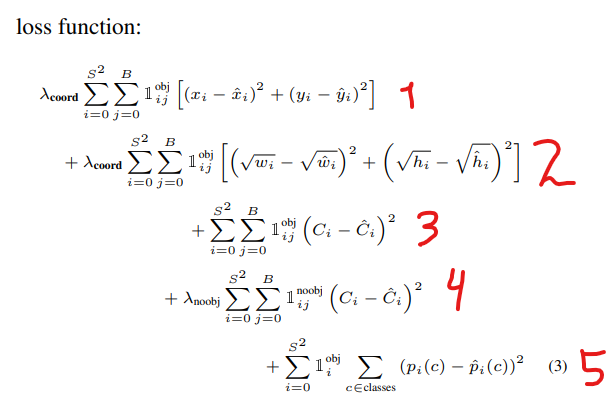



In [ ]:
# https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch
# https://github.com/makora9143/yolo-pytorch/blob/master/yolov1/loss.py

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5
        self.epsilon = 1e-20

    def forward(self, predictions, target):
        predictions = predictions.reshape(target.shape)
        batch_size = target.shape[0]

        first_row_of_loss = 0.0
        second_row_of_loss = 0.0
        third_row_of_loss = 0.0
        fourth_row_of_loss = 0.0
        fifth_row_of_loss = 0.0

        for batch in range(batch_size):
            
            for i in range(self.S):
                
                for k in range(self.S):
                    
                    if target[batch, i, k, self.C+5-1] == 1:
                        true_bbox = target[batch, i, k, self.C:self.C+4]
                        ious = []
                        
                        for j in range(self.B):
                            pred_bbox = predictions[batch, i, k, self.C+5*j:self.C+4+5*j]
                            iou = intersection_over_union(true_bbox,pred_bbox)
                            ious.append(iou)

                        if ious[0] > ious[1]:
                            pointer = 0
                            obj_conf = ious[0]
                        else:
                            obj_conf = ious[1]
                            pointer = 5
                        noobj_conf = 0

                        # first row of YOLO loss (xi and yi)
                        xi = target[batch, i, k, self.C+pointer:self.C+pointer+1]
                        xi_pred = predictions[batch, i, k, self.C+pointer:self.C+pointer+1]
                        yi = target[batch, i, k, self.C+pointer+1]
                        yi_pred = predictions[batch, i, k, self.C+pointer+1]
                        first_row_of_loss += self.mse(xi, xi_pred) + self.mse(xi, xi_pred)
                        
                        # second row of YOLO loss (wi and hi)
                        sqrt_wi = torch.sqrt(abs(target[batch, i, k, self.C+pointer+2:self.C+pointer+3]))
                        sqrt_wi_pred = torch.sqrt(abs(predictions[batch, i, k, self.C+pointer+2:self.C+pointer+3]))
                        sqrt_hi = torch.sqrt(abs(target[batch, i, k, self.C+pointer+3:self.C+pointer+4]))
                        sqrt_hi_pred = torch.sqrt(abs(predictions[batch, i, k, self.C+pointer+3:self.C+pointer+4]))
                        second_row_of_loss += self.mse(sqrt_wi, sqrt_wi_pred) + \
                                              self.mse(sqrt_hi, sqrt_hi_pred)

                        # third row of YOLO loss (obj Ci)
                        obj_conf_pred = predictions[batch, i, k, self.C+5+pointer-1:self.C+5+pointer]
                        third_row_of_loss += self.mse(obj_conf, obj_conf_pred)

                        # fourth row of YOLO loss (noobj Ci)
                        noobj_conf_pred = predictions[batch, i, k, self.C+5+abs(5-pointer)-1:self.C+5+abs(5-pointer)]
                        fourth_row_of_loss += torch.sum((noobj_conf - noobj_conf_pred) ** 2)

                        # fifth row of YOLO loss (classes)
                        pic = target[batch, i, k, :self.C]
                        pic_pred = predictions[batch, i, k, :self.C]
                        fifth_row_of_loss += self.mse(pic, pic_pred)
                    else:
                        noobj_confidence = 0
                        fourth_row_of_loss += torch.sum((noobj_confidence - predictions[batch, i, k, [self.C+5-1, self.C+5+5-1]]) ** 2)

        total_loss = (self.lambda_coord*first_row_of_loss + 
                      self.lambda_coord*second_row_of_loss +
                      third_row_of_loss +
                      self.lambda_noobj*fourth_row_of_loss +
                      fifth_row_of_loss)
        return total_loss / batch_size

## Реализуйте дополнительные функции из статьи - 2 балла

In [ ]:
# https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch/notebook#Predictions

def bbox_converter(tensor:torch.tensor, S=7, C=3, B=2, is_pred:bool=False):
    result = []
    batch_size = tensor.shape[0]
    tensor = tensor.reshape(batch_size, S, S, 5*B + C)

    # get all bboxes (x_cell, y_cell, w_cell, h_cell)
    bboxes = [tensor[..., C+5*b:C+(b+1)*5-1] for b in range(B)]
    # get all confidence (for target c=1)
    confidences = torch.cat(([tensor[..., C+b*5-1].unsqueeze(0) for b in range(B)]), 
                            dim=0)
    
    # most confident bbox (for target - first bbox)
    high_confident = confidences.argmax(0).unsqueeze(-1)
    best_boxes = bboxes[0] * (1 - high_confident) + high_confident * bboxes[1]

    # ratio to image
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1).to(device)
    xs = 1/S * (best_boxes[..., :1] + cell_indices)
    ys = 1/S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    ws_hs = 1/S *(best_boxes[..., 2:4])
    # print(best_boxes[..., 2:3])

    converted_coordinates = torch.cat((xs, ys, ws_hs), dim=-1)
    predicted_class = tensor[..., :C].argmax(-1).unsqueeze(-1) # from 0,1,0 -> 1
    best_confidence = torch.max(tensor[..., C+4], 
                                tensor[..., C+4+5]).unsqueeze(-1)

    result = torch.cat((predicted_class, best_confidence,
                                  converted_coordinates), dim=-1)

    return result

def cellbox_to_bbox(tensor:torch.tensor, S=7):
    batch_size = tensor.shape[0]
    converted_pred = bbox_converter(tensor).reshape(batch_size, S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(tensor.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def non_max_suppression(bboxes, iou_threshold, threshold):
    sorted_bboxes = sorted(bboxes, reverse=True, key=lambda x: x[1])
    accepted_bboxes = [bbox for bbox in sorted_bboxes if bbox[1] > threshold]
    result_bboxes = []

    while len(accepted_bboxes) > 0:
        current_bbox = accepted_bboxes.pop(0)

        for bbox in accepted_bboxes:
            if current_bbox[0] != bbox[0]:
                iou = intersection_over_union(torch.tensor(current_bbox[2:]),
                                              torch.tensor(bbox[2:]))
                if iou > iou_threshold:
                    accepted_bboxes.remove(bbox)

        result_bboxes.append(current_bbox)

    return result_bboxes

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    all_pred_bboxes = []
    all_true_bboxes = []
    
    model.eval()
    index = 0
    durations = []
    for iteration, batch in enumerate(loader):
        start = time.time()
        image, label_matrix = batch
        image, label_matrix = image.to(device), label_matrix.to(device)
        batch_size = image.shape[0]
        
        with torch.no_grad():
            pred = model(image)
        
        # print(label_matrix[..., C:])
        true_bboxes = cellbox_to_bbox(label_matrix)
        pred_bboxes = cellbox_to_bbox(pred)

        for batch_idx in range(batch_size):
            non_maximum_supression_bboxes = non_max_suppression(
                pred_bboxes[batch_idx], iou_threshold=iou_threshold,
                threshold=threshold
            )

            for nms_bbox in non_maximum_supression_bboxes:
                all_pred_bboxes.append([index] + nms_bbox)

            for bbox in true_bboxes[batch_idx]:
                # check confidence
                if bbox[1] > threshold:
                    all_true_bboxes.append([index] + bbox)

        index += 1

        end = time.time()
        elapsed_time = end - start

        durations.append(elapsed_time)
    model.train()

    return all_pred_bboxes, all_true_bboxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [ ]:
def YOLOtrain(model, train_dataloader:DataLoader, 
              loss_function, optimizer):
    model.train()
    train_loss = 0.0

    for data in tqdm(train_dataloader):
        optimizer.zero_grad()

        image, label = data
        image, label = image.to(device), label.to(device)
        
        preds = model(image)
        loss = loss_function(preds, label)

        train_loss += loss.data.item()

        loss.backward()
        optimizer.step()
    
    wandb.log({"train loss": train_loss})
    return train_loss

In [ ]:
def YOLOeval(model, test_dataloader:DataLoader, 
              loss_function):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for data in tqdm(test_dataloader):

            image, label = data
            image, label = image.to(device), label.to(device)
            
            preds = model(image)
            loss = loss_function(preds, label)

            test_loss += loss.data.item()
            
    wandb.log({"test loss": test_loss})
    return test_loss

In [ ]:
wandb.init(entity="sir_kolbas", project="yolo")
wandb.watch_called = False 

config = wandb.config         
config.batch_size = 4          
config.test_batch_size = 4   
config.epochs = 50             
config.lr = 1e-5                     
config.no_cuda = False         
config.seed = 2002               
config.log_interval = 10

In [ ]:
model = YOLO().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=10, threshold=1e-4, threshold_mode='abs')
loss_fn = YoloLoss()

In [ ]:
wandb.watch(model, log="all")

for epoch in range(50):
    if epoch in range(9):
        print(f'epoch №0{epoch+1} is currently running...')
    else:
        print(f'epoch №{epoch+1} is currently running...')

    train_loss = YOLOtrain(model=model, train_dataloader=train_dataloader,
              optimizer=optimizer, loss_function=loss_fn)
    val_loss = YOLOeval(model=model, test_dataloader=val_dataloader, 
                        loss_function=loss_fn)
    scheduler.step(val_loss)
    print(f'train loss: {train_loss} \ntest loss: {val_loss}')

epoch №01 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 740.2133190631866 
test loss: 128.1767659187317
epoch №02 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 573.3585138320923 
test loss: 114.7960467338562
epoch №03 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 577.43985414505 
test loss: 112.16533970832825
epoch №04 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 443.6929352283478 
test loss: 95.90062308311462
epoch №05 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 373.8707376718521 
test loss: 80.29687261581421
epoch №06 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 350.16750133037567 
test loss: 82.32704031467438
epoch №07 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 303.6504634618759 
test loss: 80.9863612651825
epoch №08 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 283.9552472829819 
test loss: 87.68239235877991
epoch №09 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 285.35698914527893 
test loss: 74.02799940109253
epoch №10 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 281.469233751297 
test loss: 77.7805905342102
epoch №11 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 248.41591894626617 
test loss: 72.56939697265625
epoch №12 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 254.51518952846527 
test loss: 73.44772505760193
epoch №13 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 256.726863861084 
test loss: 73.90654838085175
epoch №14 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 241.72153329849243 
test loss: 66.33824038505554
epoch №15 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 252.6914485692978 
test loss: 71.95657074451447
epoch №16 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 244.97635734081268 
test loss: 77.51768958568573
epoch №17 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 247.64365088939667 
test loss: 66.39600014686584
epoch №18 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 243.0128960609436 
test loss: 71.5904871225357
epoch №19 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 240.29309165477753 
test loss: 73.16199290752411
epoch №20 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 243.65429425239563 
test loss: 64.4309458732605
epoch №21 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 236.7618653178215 
test loss: 73.3810111284256
epoch №22 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 252.76844489574432 
test loss: 65.88774919509888
epoch №23 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 253.22394275665283 
test loss: 74.30326747894287
epoch №24 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 253.81993865966797 
test loss: 61.82423782348633
epoch №25 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 234.8151044845581 
test loss: 68.39752984046936
epoch №26 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 224.83105367422104 
test loss: 69.96106719970703
epoch №27 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 229.69450914859772 
test loss: 68.03933644294739
epoch №28 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 219.30936801433563 
test loss: 61.699389696121216
epoch №29 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 214.81534588336945 
test loss: 64.54638540744781
epoch №30 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 207.84528505802155 
test loss: 61.51670789718628
epoch №31 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 206.59069156646729 
test loss: 65.02779281139374
epoch №32 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 197.90237802267075 
test loss: 69.94325733184814
epoch №33 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 212.7940136194229 
test loss: 75.36099147796631
epoch №34 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 218.7760996222496 
test loss: 66.8750057220459
epoch №35 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 207.33574604988098 
test loss: 58.965014696121216
epoch №36 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 210.17699670791626 
test loss: 56.35138988494873
epoch №37 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 211.99173974990845 
test loss: 60.98104655742645
epoch №38 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 199.931723177433 
test loss: 69.49388909339905
epoch №39 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 195.6239475607872 
test loss: 58.366238713264465
epoch №40 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 211.2048498392105 
test loss: 66.3697247505188
epoch №41 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 196.37037074565887 
test loss: 65.28455173969269
epoch №42 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 200.7650147676468 
test loss: 62.995388984680176
epoch №43 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 211.2441999912262 
test loss: 72.17062640190125
epoch №44 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 208.0992500782013 
test loss: 63.090609550476074
epoch №45 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 184.38835608959198 
test loss: 71.40407824516296
epoch №46 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 203.88071942329407 
test loss: 65.90502297878265
epoch №47 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 193.70954048633575 
test loss: 61.97707557678223
epoch №48 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 176.9260060787201 
test loss: 44.84811997413635
epoch №49 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 139.8547425866127 
test loss: 42.54413402080536
epoch №50 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 125.82682001590729 
test loss: 39.821332931518555


In [ ]:
YOLOeval(model, val_dataloader, loss_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

39.821332931518555

In [ ]:
api = wandb.Api()
run = api.run("sir_kolbas/yolo/1jkqqwad")
run.display(height=1080)

True

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [ ]:
import matplotlib.patches as patches

S, B, C = 7, 2, 3

"""
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
"""

def get_class_and_color(search_tag):
    color = ''
    for class_, tag in class2tag.items():
        if tag == search_tag:
            if tag == 1:
                color = 'g'
            elif tag == 2:
                color = 'orange'
            else:
                color = 'y'
            return (class_, color)

def visualize_preds(dataset, model, idx=0, samples=10, cols=5, random=True):
    dataset = copy.deepcopy(dataset)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=((16, 8)))

    for i in range(samples):
        
        if random:
            idx = np.random.randint(1,len(dataset))
        
        image, target_tensor = dataset[idx]
        preds = model(image.to(device))[0]
        
        image = image.detach().numpy()
        image = image.swapaxes(0,1)
        image = image.swapaxes(1,2)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_size, _, _ = image.shape
        
        cell_size = image_size/S
        x_centres = []
        y_centres = []
        ax.ravel()[i].imshow(image)
        
        for k in range(S):
            
            if torch.sum(target_tensor[k]) > 0:
                
                for j in range(S):
                    
                    if torch.sum(target_tensor[k][j]) > 0:
                        x_center, y_center, width, height =  target_tensor[k][j][C:C-1+5]
                        x_center_initial = (x_center + k)*cell_size
                        y_center_initial = (y_center + j)*cell_size
                        
                        width, height = width/S, height/S
                        x_min = x_center_initial - width*image_size / 2
                        y_min = y_center_initial - height*image_size / 2
                        
                        label =(target_tensor[k][j][:C]).argmax(0) + 1
                        class_, color = get_class_and_color(label)
                        rect = patches.Rectangle((x_min, y_min),
                                                  width * image_size,
                                                  height * image_size,
                                                  linewidth=1.25,
                                                  edgecolor=color,
                                                  facecolor="none",
                                                  label=class_)
                        
                        ax.ravel()[i].scatter(x_center_initial, y_center_initial, c=color)
                        ax.ravel()[i].add_patch(rect)

                        x_center, y_center, width, height =  preds[k][j][C:C-1+5].to('cpu').detach().numpy()
                        x_center_initial = (x_center + k)*cell_size
                        y_center_initial = (y_center + j)*cell_size
                        
                        width, height = width/S, height/S
                        x_min = x_center_initial - width*image_size / 2
                        y_min = y_center_initial - height*image_size / 2
                        
                        label = (preds[k][j][:C]).argmax(0) + 1
                        class_, color = get_class_and_color(label)
                        rect = patches.Rectangle((x_min, y_min),
                                                  width * image_size,
                                                  height * image_size,
                                                  linewidth=1.25,
                                                  edgecolor='black',
                                                  facecolor="none",
                                                  label=class_+'_pred')
                        
                        ax.ravel()[i].scatter(x_center_initial, y_center_initial, c='black')
                        ax.ravel()[i].add_patch(rect)

        loc = plt.matplotlib.ticker.MultipleLocator(base=image_size/dataset.S)
        
        ax.ravel()[i].xaxis.set_major_locator(loc)
        ax.ravel()[i].yaxis.set_major_locator(loc)
        ax.ravel()[i].grid(which='major', axis='both', linestyle='-', linewidth=0.25, color='grey')
        ax.ravel()[i].legend(loc='upper right')
    
    plt.suptitle('Bounding boxes', fontweight='bold')
    plt.tight_layout()
    plt.legend()
    plt.show()

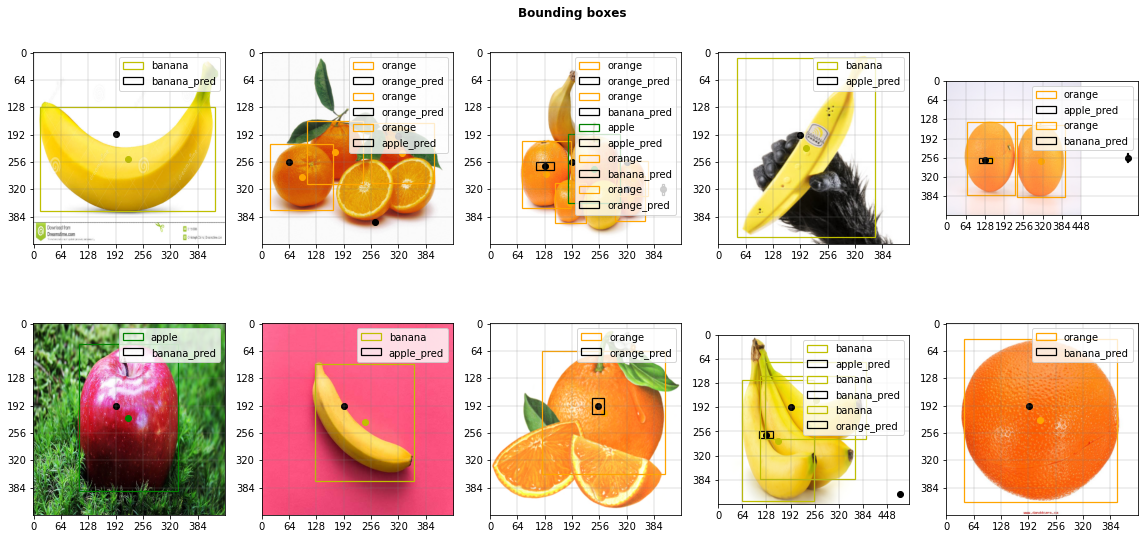

In [ ]:
visualize_preds(val_dataset, model)